In [1]:
%matplotlib inline

import time
import math
import random
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

learning_rate = 0.001
num_epochs = 5
batch_size = 128
print_step = 200

num_layers = 3
input_size = 28
time_step = 28
hidden_size = 128
output_size = 10

# Reproducibility
seed = 99
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

train_dataset = datasets.MNIST('data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

Device: cuda:0


## Long Short-term Memory

$ \begin{array}{ll}
i_{t} = \sigma(W_{ii} x_{t} + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
f_{t} = \sigma(W_{if} x_{t} + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
o_{t} = \sigma(W_{io} x_{t} + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
c_{t} = f_{t} \odot c_{t-1} + i_{t} \odot \tanh(W_{ic} x_{t} + b_{ic} + W_{hc} h_{t-1} + b_{hc}) \\
h_{t} = o_{t} \odot \tanh(c_{t}) \\
\end{array} $

In [0]:
class LSTMCell(nn.Module):
    """Long short-term memory (LSTM) cell"""

    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
        self.bias_ih = nn.Parameter(torch.Tensor(hidden_size * 4))
        self.bias_hh = nn.Parameter(torch.Tensor(hidden_size * 4))
        self.init_parameters()

    def init_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for param in self.parameters():
            nn.init.uniform_(param, -stdv, stdv)

    def forward(self, x, init_states):
        h_t_minus_1, c_t_minus_1 = init_states
        gates = torch.mm(x, self.weight_ih) + self.bias_ih + torch.mm(h_t_minus_1, self.weight_hh) + self.bias_hh
        inputgate, forgetgate, cell, outputgate = gates.chunk(4, dim=1)
        c = (torch.sigmoid(forgetgate) * c_t_minus_1) + (torch.sigmoid(inputgate) * torch.tanh(cell))
        h = torch.sigmoid(outputgate) * torch.tanh(c)
        return (h, c)


class LSTM(nn.Module):
    """Multi-layer long short-term memory (LSTM)"""

    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=False):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        layers = [LSTMCell(input_size, hidden_size)]
        for i in range(num_layers - 1):
            layers += [LSTMCell(hidden_size, hidden_size)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, init_states=None):
        # Input and output size: (seq_length, batch_size, input_size)
        # States size: (num_layers, batch_size, hidden_size)
        if self.batch_first:
            x = x.transpose(0, 1)

        self.h = torch.zeros(x.size(0), self.num_layers, x.size(1), self.hidden_size).to(x.device)
        self.c = torch.zeros(x.size(0), self.num_layers, x.size(1), self.hidden_size).to(x.device)
        if init_states is not None:
            self.h[0], self.c[0] = init_states

        inputs = x
        for i, cell in enumerate(self.net):  # Layers
            h_t, c_t = self.h[0, i].clone(), self.c[0, i].clone()
            for t in range(x.size(0)):  # Sequences
                h_t, c_t = cell(inputs[t], (h_t, c_t))
                self.h[t, i], self.c[t, i] = h_t, c_t
            inputs = self.h[:, i].clone()

        if self.batch_first:
            return self.h[:, -1].transpose(0, 1), (self.h[-1], self.c[-1])

        return self.h[:, -1], (self.h[-1], self.c[-1])

        # if init_states is not None:
        #     h_0, c_0 = init_states
        # else:
        #     h_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
        #     c_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
        #
        # inputs, outputs, h, c = x, [], [], []
        # for i, cell in enumerate(self.net):  # Layers
        #     h_t, c_t = h_0[i], c_0[i]
        #     for t in range(x.size(0)):  # Sequences
        #         h_t, c_t = cell(inputs[t], (h_t, c_t))
        #         outputs += [h_t]
        #     inputs, outputs = outputs, []
        #     h += [h_t]
        #     c += [c_t]
        #
        # if self.batch_first:
        #     return torch.stack(inputs).transpose(0, 1), (torch.stack(h), torch.stack(c))
        #
        # return torch.stack(inputs), (torch.stack(h), torch.stack(c))


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x, None)
        out = self.fc(out[:, -1, :])
        return out

Train on 60000 samples, test on 10000 samples
Epoch 1/5
step: 200/469 - loss: 1.0843 - acc: 0.610 - test_loss: 0.4426 - test_acc: 0.857
step: 400/469 - loss: 0.6814 - acc: 0.763 - test_loss: 0.1894 - test_acc: 0.944
step: 469/469 - loss: 0.6086 - acc: 0.790 - test_loss: 0.1793 - test_acc: 0.949
Epoch 2/5
step: 200/469 - loss: 0.1559 - acc: 0.953 - test_loss: 0.1368 - test_acc: 0.961
step: 400/469 - loss: 0.1360 - acc: 0.959 - test_loss: 0.1056 - test_acc: 0.968
step: 469/469 - loss: 0.1315 - acc: 0.961 - test_loss: 0.1219 - test_acc: 0.964
Epoch 3/5
step: 200/469 - loss: 0.0935 - acc: 0.973 - test_loss: 0.1032 - test_acc: 0.970
step: 400/469 - loss: 0.0863 - acc: 0.975 - test_loss: 0.0737 - test_acc: 0.978
step: 469/469 - loss: 0.0839 - acc: 0.975 - test_loss: 0.0786 - test_acc: 0.979
Epoch 4/5
step: 200/469 - loss: 0.0647 - acc: 0.981 - test_loss: 0.0834 - test_acc: 0.975
step: 400/469 - loss: 0.0638 - acc: 0.981 - test_loss: 0.0645 - test_acc: 0.981
step: 469/469 - loss: 0.0625 - acc

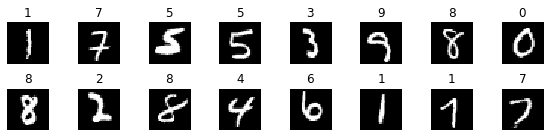

In [3]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

steps = len(train_loader)
test_total = len(test_loader.dataset)

print('Train on {} samples, test on {} samples'.format(len(train_loader.dataset), test_total))

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))

    running_loss = 0.0
    corrects = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(-1, time_step, input_size).to(device)
        labels = labels.to(device, non_blocking=True)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels).item()
        total += inputs.size(0)

        if (i + 1) % print_step == 0 or (i + 1) == steps:
            # Test phase
            test_running_loss = 0.0
            test_corrects = 0

            for inputs, labels in test_loader:
                inputs = inputs.view(-1, time_step, input_size).to(device)
                labels = labels.to(device)

                # Prevent tracking history
                with torch.no_grad():
                    outputs = model(inputs)

                    loss = criterion(outputs, labels)

                    test_running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    test_corrects += torch.sum(preds == labels).item()

            train_acc = corrects / total
            train_loss = running_loss / total
            test_acc = test_corrects / test_total
            test_loss = test_running_loss / test_total

            print('step: {}/{} - loss: {:.4f} - acc: {:.3f} - test_loss: {:.4f} - test_acc: {:.3f}'.format(
                i + 1, steps, train_loss, train_acc, test_loss, test_acc))

elapsed_time = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

inputs = inputs.cpu().numpy()
preds = preds.cpu().numpy()
labels = labels.cpu().numpy()
n_rows, n_cols = (2, 8)
plt.figure(figsize=(n_cols, n_rows))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')
    plt.title(preds[i])
    plt.imshow(inputs[i], cmap='gray')
plt.tight_layout()
plt.show()

## Gated Recurrent Unit

$ \begin{array}{ll}
r_{t} = \sigma(W_{ir} x_{t} + b_{ir} + W_{hr} h_{t-1} + b_{hr}) \\
z_{t} = \sigma(W_{iz} x_{t} + b_{iz} + W_{hz} h_{t-1} + b_{hz}) \\
\tilde{h}_{t} = \tanh(W_{ih} x_{t} + b_{ih} + W(r_{t} \odot h_{t-1})) \\
h_{t} = (1 - z_{t}) \odot h_{t-1} + z_{t} \odot \tilde{h}_{t}
\end{array} $

In [0]:
class GRUCell(nn.Module):
    """Gated recurrent unit (GRU) cell"""

    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.Tensor(input_size, hidden_size * 3))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 3))
        self.bias_ih = nn.Parameter(torch.Tensor(hidden_size * 3))
        self.bias_hh = nn.Parameter(torch.Tensor(hidden_size * 3))
        self.init_parameters()

    def init_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for param in self.parameters():
            nn.init.uniform_(param, -stdv, stdv)

    def forward(self, x, h_t_minus_1):
        idx = self.hidden_size * 2
        gates_ih = torch.mm(x, self.weight_ih) + self.bias_ih
        gates_hh = torch.mm(h_t_minus_1, self.weight_hh[:, :idx]) + self.bias_hh[:idx]
        resetgate_i, updategate_i, output_i = gates_ih.chunk(3, dim=1)
        resetgate_h, updategate_h = gates_hh.chunk(2, dim=1)
        r = torch.sigmoid(resetgate_i + resetgate_h)
        z = torch.sigmoid(updategate_i + updategate_h)
        h_tilde = torch.tanh(output_i + (torch.mm((r * h_t_minus_1), self.weight_hh[:, idx:]) + self.bias_hh[idx:]))
        h = (1 - z) * h_t_minus_1 + z * h_tilde
        return h


class GRU(nn.Module):
    """Multi-layer gated recurrent unit (GRU)"""

    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=False):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        layers = [GRUCell(input_size, hidden_size)]
        for i in range(num_layers - 1):
            layers += [GRUCell(hidden_size, hidden_size)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, init_state=None):
        # Input and output size: (seq_length, batch_size, input_size)
        # State size: (num_layers, batch_size, hidden_size)
        if self.batch_first:
            x = x.transpose(0, 1)

        self.h = torch.zeros(x.size(0), self.num_layers, x.size(1), self.hidden_size).to(x.device)
        if init_state is not None:
            self.h[0, :] = init_state

        inputs = x
        for i, cell in enumerate(self.net):  # Layers
            h_t = self.h[0, i].clone()
            for t in range(x.size(0)):  # Sequences
                h_t = cell(inputs[t], h_t)
                self.h[t, i] = h_t
            inputs = self.h[:, i].clone()

        if self.batch_first:
            return self.h[:, -1].transpose(0, 1), self.h[-1]

        return self.h[:, -1], self.h[-1]

        # if init_state is not None:
        #     h_0 = init_state
        # else:
        #     h_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
        #
        # inputs, outputs, h = x, [], []
        # for i, cell in enumerate(self.net):  # Layers
        #     h_t = h_0[i]
        #     for t in range(x.size(0)):  # Sequences
        #         h_t = cell(inputs[t], h_t)
        #         outputs += [h_t]
        #     inputs, outputs = outputs, []
        #     h += [h_t]
        #
        # if self.batch_first:
        #     return torch.stack(inputs).transpose(0, 1), torch.stack(h)
        #
        # return torch.stack(inputs), torch.stack(h)


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x, None)
        out = self.fc(out[:, -1, :])
        return out

Train on 60000 samples, test on 10000 samples
Epoch 1/5
step: 200/469 - loss: 0.8217 - acc: 0.720 - test_loss: 0.2869 - test_acc: 0.916
step: 400/469 - loss: 0.5191 - acc: 0.828 - test_loss: 0.1661 - test_acc: 0.951
step: 469/469 - loss: 0.4667 - acc: 0.845 - test_loss: 0.1462 - test_acc: 0.957
Epoch 2/5
step: 200/469 - loss: 0.1230 - acc: 0.962 - test_loss: 0.1115 - test_acc: 0.967
step: 400/469 - loss: 0.1118 - acc: 0.966 - test_loss: 0.0934 - test_acc: 0.972
step: 469/469 - loss: 0.1079 - acc: 0.967 - test_loss: 0.0841 - test_acc: 0.974
Epoch 3/5
step: 200/469 - loss: 0.0781 - acc: 0.976 - test_loss: 0.0788 - test_acc: 0.977
step: 400/469 - loss: 0.0751 - acc: 0.977 - test_loss: 0.0611 - test_acc: 0.981
step: 469/469 - loss: 0.0734 - acc: 0.977 - test_loss: 0.0608 - test_acc: 0.982
Epoch 4/5
step: 200/469 - loss: 0.0528 - acc: 0.983 - test_loss: 0.0471 - test_acc: 0.985
step: 400/469 - loss: 0.0516 - acc: 0.984 - test_loss: 0.0415 - test_acc: 0.989
step: 469/469 - loss: 0.0512 - acc

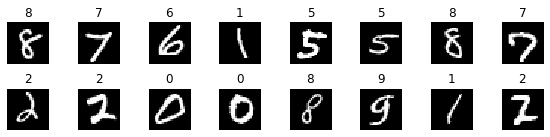

In [5]:
model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

steps = len(train_loader)
test_total = len(test_loader.dataset)

print('Train on {} samples, test on {} samples'.format(len(train_loader.dataset), test_total))

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))

    running_loss = 0.0
    corrects = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(-1, time_step, input_size).to(device)
        labels = labels.to(device, non_blocking=True)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels).item()
        total += inputs.size(0)

        if (i + 1) % print_step == 0 or (i + 1) == steps:
            # Test phase
            test_running_loss = 0.0
            test_corrects = 0

            for inputs, labels in test_loader:
                inputs = inputs.view(-1, time_step, input_size).to(device)
                labels = labels.to(device)

                # Prevent tracking history
                with torch.no_grad():
                    outputs = model(inputs)

                    loss = criterion(outputs, labels)

                    test_running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    test_corrects += torch.sum(preds == labels).item()

            train_acc = corrects / total
            train_loss = running_loss / total
            test_acc = test_corrects / test_total
            test_loss = test_running_loss / test_total

            print('step: {}/{} - loss: {:.4f} - acc: {:.3f} - test_loss: {:.4f} - test_acc: {:.3f}'.format(
                i + 1, steps, train_loss, train_acc, test_loss, test_acc))

elapsed_time = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

inputs = inputs.cpu().numpy()
preds = preds.cpu().numpy()
labels = labels.cpu().numpy()
n_rows, n_cols = (2, 8)
plt.figure(figsize=(n_cols, n_rows))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')
    plt.title(preds[i])
    plt.imshow(inputs[i], cmap='gray')
plt.tight_layout()
plt.show()